In [225]:
import pandas as pd
import pymssql
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt

In [226]:
from config import database
from config import Mouse
from config import Virus
from config import Protein
from config import Biotin
from config import Fraction
from config import Protein_Id
from config import Gene
from config import Protein_Description
from config import Peptide
from config import username
from config import password
from config import server

In [227]:
try:
    conn = pymssql.connect(server,username, password,database)

    cursor = conn.cursor()
    query = f"""
    SELECT 
        M.Sample_Name,
        P.Protein_Name,
        V.Virus_Label,
        B.Biotin_Label,
        F.Fraction_Label,
        MP.Hits
        FROM Mouse_Protein AS MP 
    INNER JOIN {Mouse} AS M on MP.Mouse_ID = M.Mouse_ID
    INNER JOIN {Protein} AS P on MP.Protein_ID = P.Protein_ID
    INNER JOIN {Virus} AS V on M.Virus_ID = V.Virus_ID
    INNER JOIN {Biotin} AS B on M.Biotin_ID = B.Biotin_ID
    INNER JOIN {Fraction} AS F on M.Fraction_ID = F.Fraction_ID
    INNER JOIN {Protein_Id} AS PI on P.Protein_Id_ID = PI.Protein_Id_ID
    INNER JOIN {Gene} AS G on P.Gene_ID = G.Gene_ID
    INNER JOIN {Protein_Description} AS PD on P.Description_ID = PD.Description_ID
    INNER JOIN {Peptide} AS PE on P.Peptide_ID = PE.Peptide_ID
    ORDER BY MP.Hits DESC
    """
    main_df = pd.read_sql(query, conn)
except Exception as e:
    print(e)
main_df.head()

,Sample_Name,Protein_Name,Virus_Label,Biotin_Label,Fraction_Label,Hits
0,3062-MRU-LP1_11,NFH_MOUSE,TDP43-TurboID,72,LP1,5.225510e+09
1,3062-MRU-LP1_11,NFL_MOUSE,TDP43-TurboID,72,LP1,4.174620e+09
2,3062-MRU-LP1_11,H2A1B_MOUSE;H2A1C_MOUSE;H2A1D_MOUSE;H2A1E_MOUS...,TDP43-TurboID,72,LP1,3.127040e+09
3,3062-MRU-LP1_11,TBA1A_MOUSE,TDP43-TurboID,72,LP1,3.018330e+09
4,3062-MRU-LP1_11,PLEC-6_MOUSE;PLEC-7_MOUSE;PLEC-8_MOUSE,TDP43-TurboID,72,LP1,2.856640e+09


In [228]:
print("Virus types:", list(main_df["Virus_Label"].unique()))
print("Biotin types:", list(main_df["Biotin_Label"].unique()))
print("Fraction types:", list(main_df["Fraction_Label"].unique()))
print("Total rows of data:", len(main_df), "\nWith 24 data frame combos")

Virus types: ['TDP43-TurboID', 'TDP43TurboID', 'TurboID']
Biotin types: ['72', '1.5', 'saline']
Fraction types: ['LP1', 'LS1', 'cortex', 'whole brain', 'Nuclear']
Total rows of data: 286301 
With 24 data frame combos


In [229]:
def labeler(word):
    word_list = word.split("_")
    labels = ["Virus:", "Biotin:", "Fraction:", "Sample:"]
    result = ''
    for i in range(len(word_list)):
        if(word_list[i] == "15" or word_list[i] == 15): word_list[i] = "1.5"
        if(i != (len(word_list) - 1)):
            result += labels[i] + ' ' + word_list[i] + '\n'
        else:
            result += labels[i] + ' ' + word_list[i]
    return result

# Protein Sets too look into

---
## All diseased samples
#### Q331K_M1 | Q331K_M2 | WT_M3 | WT_M3

In [230]:
Q331K_M1 = main_df[main_df["Sample_Name"] == "Q331K_M1"]
Q331K_M2 = main_df[main_df["Sample_Name"] == "Q331K_M2"]
WT_M3 = main_df[main_df["Sample_Name"] == "WT_M3"]
WT_M4 = main_df[main_df["Sample_Name"] == "WT_M4"]
print(f"Check that all subsets have information\n1:{len(Q331K_M1)}, 2:{len(Q331K_M2)}, 3:{len(WT_M3)}, 4:{len(WT_M4)}")

Check that all subsets have information
1:42746, 2:42746, 3:42746, 4:42746


## Cluster Heat Map of all proteins

Nummber of Proteins captured: 702


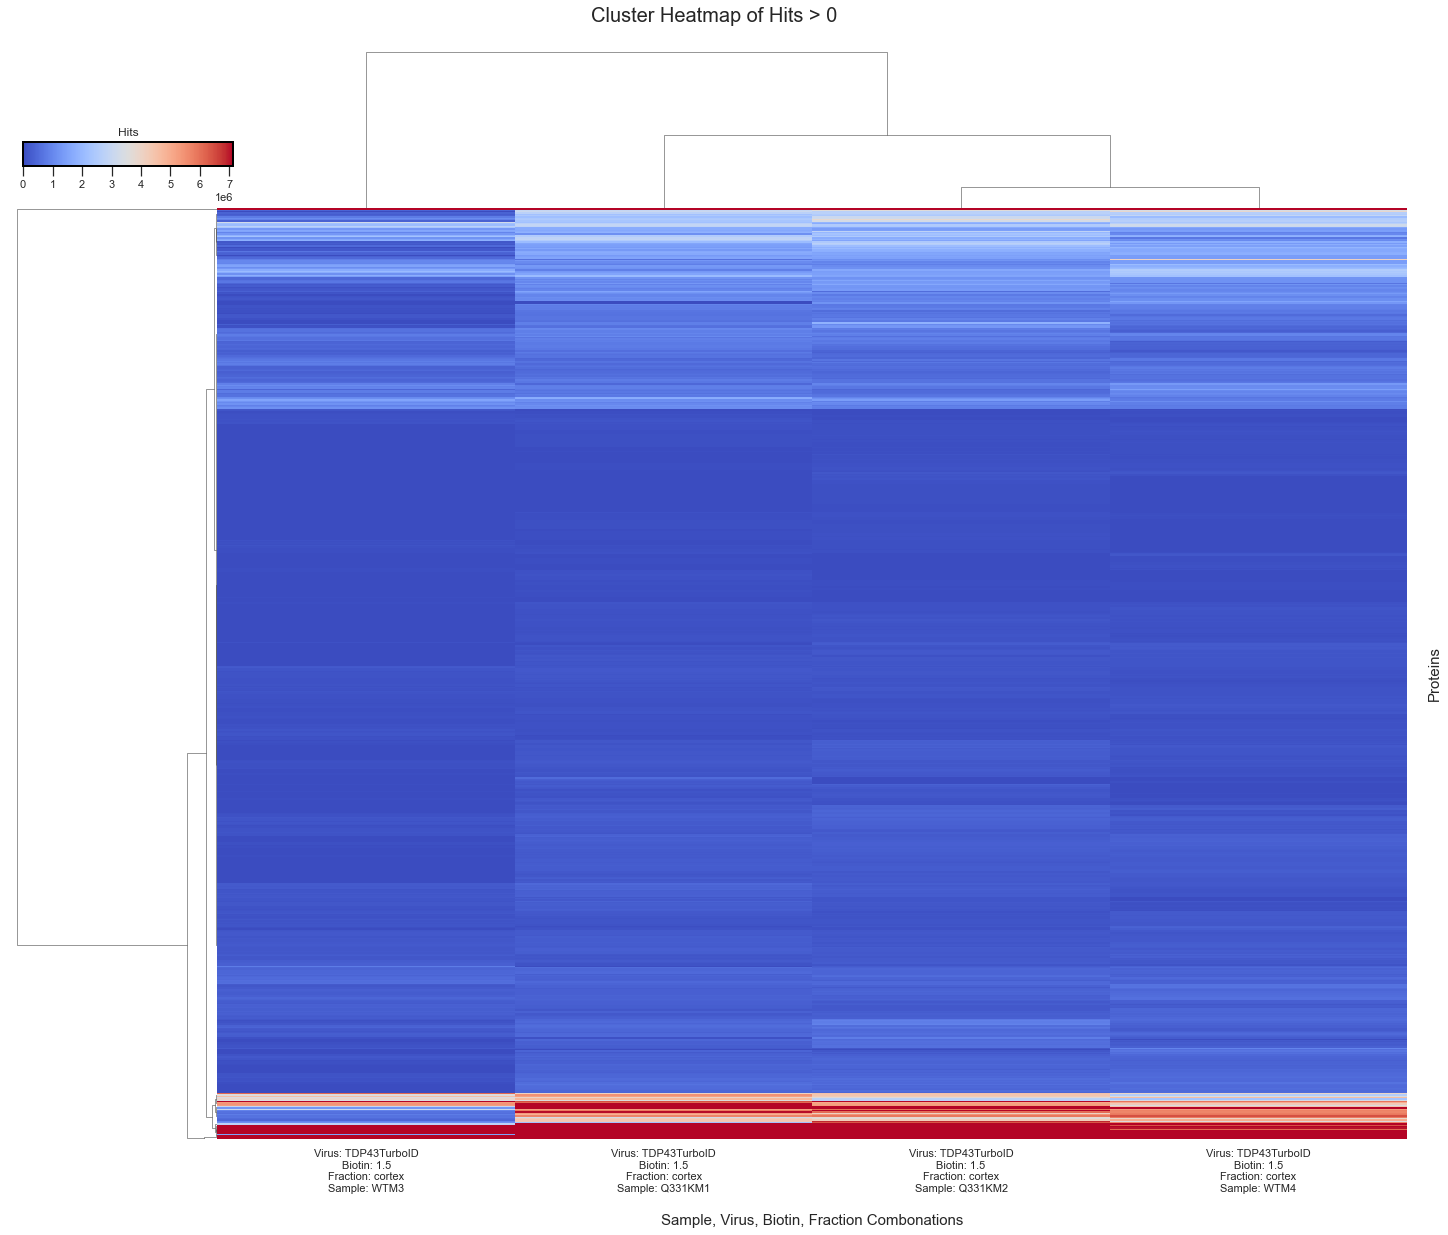

In [231]:
Q331K_M1 = Q331K_M1.copy().groupby("Protein_Name").mean().reset_index()
Q331K_M2 = Q331K_M2.copy().groupby("Protein_Name").mean().reset_index()
WT_M3 = WT_M3.copy().groupby("Protein_Name").mean().reset_index()
WT_M4 = WT_M4.copy().groupby("Protein_Name").mean().reset_index()


Q331K_M1 = Q331K_M1.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_Q331KM1")})
Q331K_M2 = Q331K_M2.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_Q331KM2")})
WT_M3 = WT_M3.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_WTM3")})
WT_M4 = WT_M4.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_WTM4")})


merge_df = Q331K_M1.merge(Q331K_M2, how = "inner", on = "Protein_Name")
merge_df = merge_df.merge(WT_M3, how = "inner", on = "Protein_Name")
merge_df = merge_df.merge(WT_M4, how = "inner", on = "Protein_Name")

# remove non unqiue proteins 
# and remove unwanted proteins
protein_list_1 = merge_df.Protein_Name.to_list()
remove_list = []
bad_proteins = ["KRT", "ACTB", "SERPIN", "ITIH", "ALB", "PCCA", "MCCC1", "ACACA", "KRT78", "TARDBP", "TUBB3", "TUBA1A", "H3-3B;H3-5;H3C1;H3C13", "PCCB", "TRY10", "VCL", "TUBA4A", "ALB"]
for i in range(len(protein_list_1)):
    for j in range(len(bad_proteins)):
            if(protein_list_1[i][0:len(bad_proteins[j])].upper() == bad_proteins[j]):
                remove_list.append(i)
    
merge_df = merge_df.drop(remove_list, axis = 0)

protein_list_1 = merge_df.Protein_Name.to_list()

merge_df["Protein_Name"] = merge_df.apply(lambda x : x["Protein_Name"].split(";")[0] if len(x["Protein_Name"].split(";")) != 1 else x["Protein_Name"], axis = 1)
merge_df = merge_df.set_index('Protein_Name')


 # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Chagne the limit to find different visuals
limit = 0

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

merge_filtered_df = merge_df[(merge_df.sum(axis=1) > limit)]

x_labels_order = sorted(merge_filtered_df.columns)

print("Nummber of Proteins captured:", len(merge_filtered_df))
sns.set_theme(style='white')

kws = dict(cbar_kws=dict(ticks=[x for x in range(0, 500000000, 1000000)], orientation='horizontal'), figsize=(20,17))

# Default plot
g = sns.clustermap(merge_filtered_df.reindex(x_labels_order, axis = 1), cmap='coolwarm',dendrogram_ratio = (0.15, 0.15), metric="euclidean", method = "ward",  **kws, robust = True, yticklabels=False)

g.fig.subplots_adjust( top = 0.95 )
g.fig.suptitle(f'Cluster Heatmap of Hits > {limit:,}', size = 20)
g.ax_heatmap.set_xlabel('\nSample, Virus, Biotin, Fraction Combonations', size = 15)
g.ax_heatmap.set_ylabel('\nProteins', size = 15)



x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0, 0.85, g.ax_row_dendrogram.get_position().width, 0.02])
g.ax_cbar.set_title('Hits')
g.ax_cbar.tick_params(axis='x', length=10)
for spine in g.ax_cbar.spines:
    g.ax_cbar.spines[spine].set_color('black')
    g.ax_cbar.spines[spine].set_linewidth(2)

# Show the graph
plt.show()

## Cluster Heat Map of proteins that show up in every sample and twice over in similar samples


Nummber of Proteins captured: 654


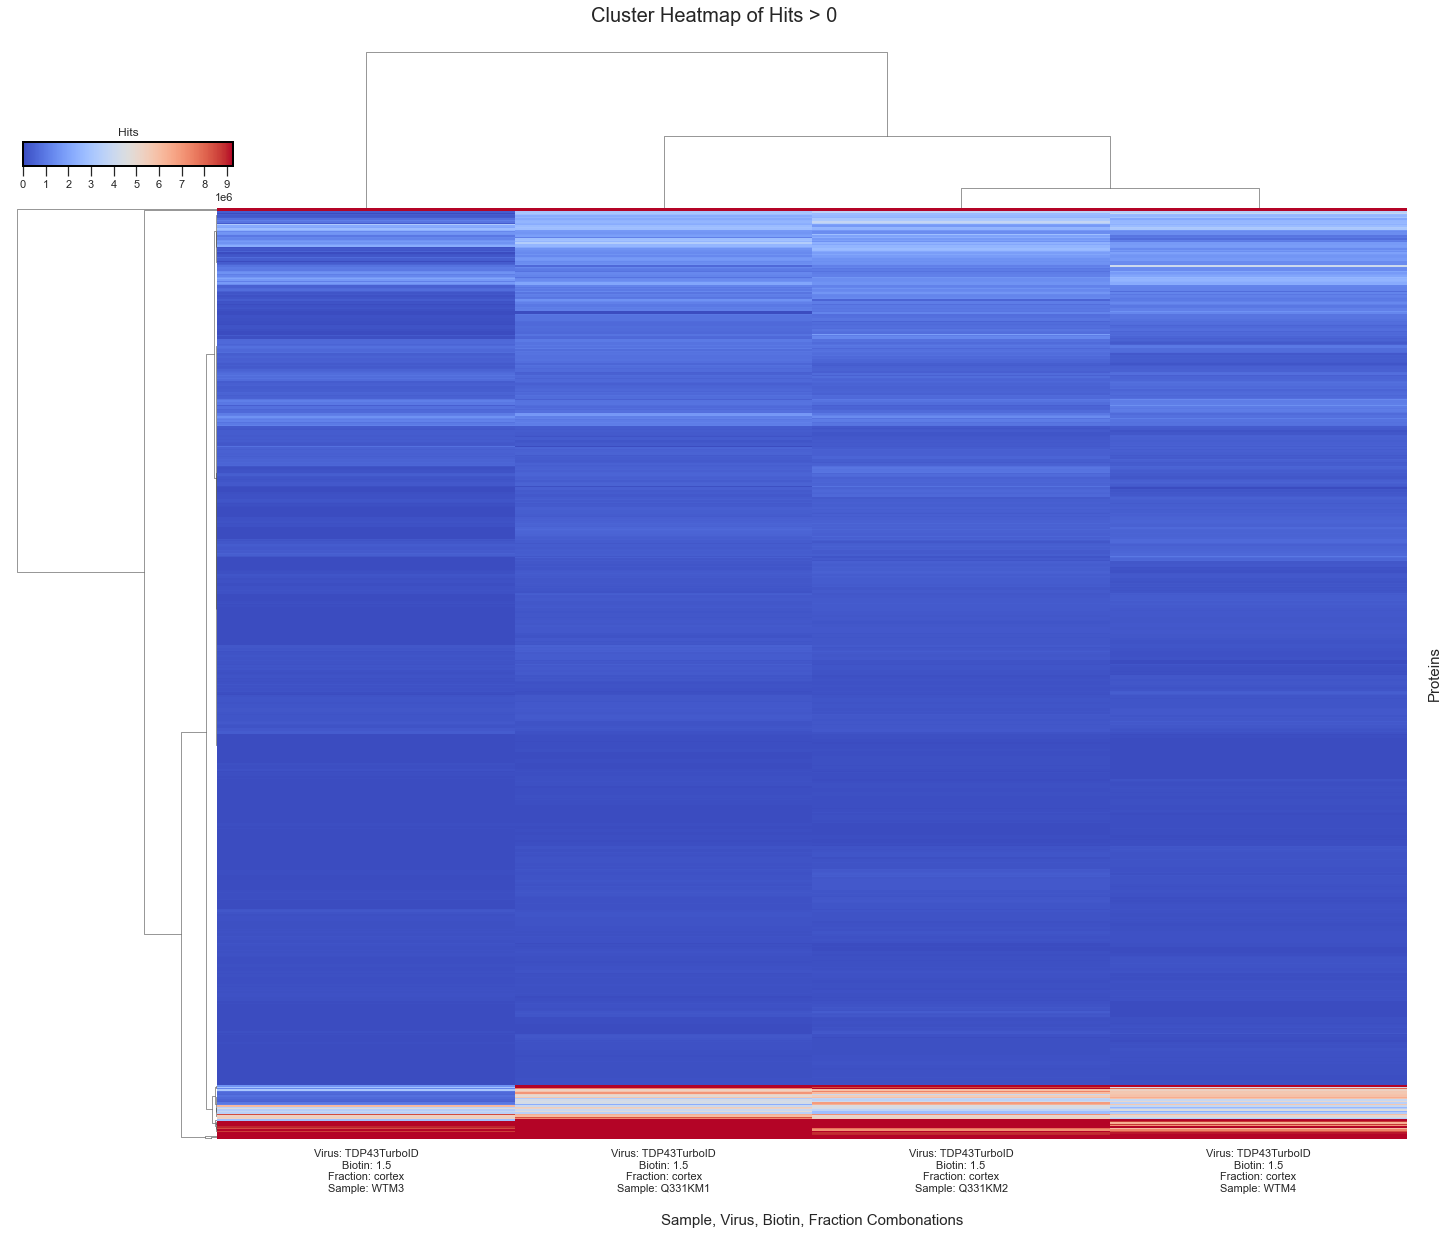

In [232]:
Q331K_M1 = main_df[main_df["Sample_Name"] == "Q331K_M1"]
Q331K_M2 = main_df[main_df["Sample_Name"] == "Q331K_M2"]
WT_M3 = main_df[main_df["Sample_Name"] == "WT_M3"]
WT_M4 = main_df[main_df["Sample_Name"] == "WT_M4"]

Q331K_M1 = Q331K_M1.copy().groupby("Protein_Name").mean().reset_index()
Q331K_M2 = Q331K_M2.copy().groupby("Protein_Name").mean().reset_index()
WT_M3 = WT_M3.copy().groupby("Protein_Name").mean().reset_index()
WT_M4 = WT_M4.copy().groupby("Protein_Name").mean().reset_index()

# remove unique proteins
def protein_finder(df):
    protein_keeper = []
    protein_list = df.Protein_Name.to_list()
    Hit_list = df.Hits.to_list()
    for i in range(len(protein_list)):
        if(Hit_list[i] != 0):
            protein_keeper.append(protein_list[i])
    return protein_keeper

proteins_keep = protein_finder(Q331K_M1) + protein_finder(Q331K_M2) + protein_finder(WT_M3) + protein_finder(WT_M4)
proteins_keep = list(set([x for x in proteins_keep if proteins_keep.count(x) > 1]))

proteins_keep_Q3 = protein_finder(Q331K_M1) + protein_finder(Q331K_M2)
proteins_keep_Q3 = list(set([x for x in proteins_keep_Q3 if proteins_keep_Q3.count(x) > 1]))

proteins_keep_WT = protein_finder(WT_M3) + protein_finder(WT_M4)
proteins_keep_WT = list(set([x for x in proteins_keep_WT if proteins_keep_WT.count(x) > 1]))


Q331K_M1 = Q331K_M1.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_Q331KM1")})
Q331K_M2 = Q331K_M2.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_Q331KM2")})
WT_M3 = WT_M3.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_WTM3")})
WT_M4 = WT_M4.copy()[["Protein_Name", "Hits"]].rename(columns = {"Hits": labeler("TDP43TurboID_15_cortex_WTM4")})


merge_df = Q331K_M1.merge(Q331K_M2, how = "inner", on = "Protein_Name")
merge_df = merge_df.merge(WT_M3, how = "inner", on = "Protein_Name")
merge_df = merge_df.merge(WT_M4, how = "inner", on = "Protein_Name")

# remove non unqiue proteins 
# and remove unwanted proteins
protein_list = merge_df.Protein_Name.to_list()
remove_list = []
bad_proteins = ["KRT", "ACTB", "SERPIN", "ITIH", "ALB", "PCCA", "MCCC1", "ACACA", "KRT78", "TARDBP", "TUBB3", "TUBA1A", "H3-3B;H3-5;H3C1;H3C13", "PCCB", "TRY10", "VCL", "TUBA4A", "ALB"]
for i in range(len(protein_list_1)):
    for j in range(len(bad_proteins)):
            if(protein_list_1[i][0:len(bad_proteins[j])].upper() == bad_proteins[j]):
                remove_list.append(i)
    if(protein_list[i] in proteins_keep_Q3): continue
    if(protein_list[i] in proteins_keep_WT): continue
    if(protein_list[i] not in proteins_keep):
        remove_list.append(i)
        
        
merge_df = merge_df.drop(list(set(remove_list)), axis = 0)

protein_list_2 = merge_df.Protein_Name.to_list()


merge_df["Protein_Name"] = merge_df.apply(lambda x : x["Protein_Name"].split(";")[0] if len(x["Protein_Name"].split(";")) != 1 else x["Protein_Name"], axis = 1)
merge_df = merge_df.set_index('Protein_Name')


 # - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

# Chagne the limit to find different visuals
limit = 0

# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

merge_filtered_df = merge_df[(merge_df.sum(axis=1) > limit)]

x_labels_order = sorted(merge_filtered_df.columns)

print("Nummber of Proteins captured:", len(merge_filtered_df))
sns.set_theme(style='white')

kws = dict(cbar_kws=dict(ticks=[x for x in range(0, 500000000, 1000000)], orientation='horizontal'), figsize=(20,17))

# Default plot
g = sns.clustermap(merge_filtered_df.reindex(x_labels_order, axis = 1), cmap='coolwarm',dendrogram_ratio = (0.15, 0.15), metric="euclidean", method = "ward",  **kws, robust = True, yticklabels=False)

g.fig.subplots_adjust( top = 0.95 )
g.fig.suptitle(f'Cluster Heatmap of Hits > {limit:,}', size = 20)
g.ax_heatmap.set_xlabel('\nSample, Virus, Biotin, Fraction Combonations', size = 15)
g.ax_heatmap.set_ylabel('\nProteins', size = 15)



x0, _y0, _w, _h = g.cbar_pos
g.ax_cbar.set_position([x0, 0.85, g.ax_row_dendrogram.get_position().width, 0.02])
g.ax_cbar.set_title('Hits')
g.ax_cbar.tick_params(axis='x', length=10)
for spine in g.ax_cbar.spines:
    g.ax_cbar.spines[spine].set_color('black')
    g.ax_cbar.spines[spine].set_linewidth(2)

# Show the graph
plt.show()

In [233]:
print("Number of proteins found in clustermap 1 that don't appear in clustermap 2:\n" ,len([x for x in protein_list_1 if x not in protein_list_2]), "proteins")

Number of proteins found in clustermap 1 that don't appear in clustermap 2:
 53 proteins
